 # CSE 6240 Assignment 1 

Name: Qi Zheng  -- GT_username: qzheng61

## Summary

__In this assignment, four design matrices have been created, and used to train SVM prediction models and obtain the best estimations of the C values for four models respectively. Four predictions were made on the test data set provided by Kaggle, and have been submitted to Kaggle. The highest score I obtained was 0.875. ROC-AUC plots and learning curves are also generated.__

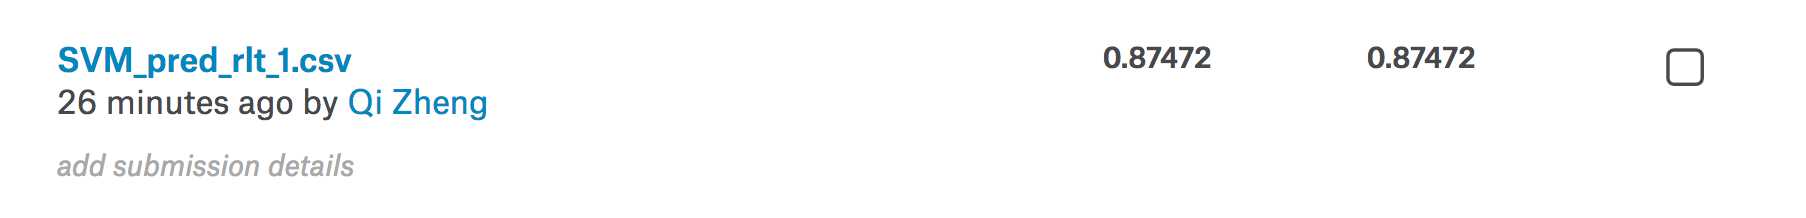

In [116]:
from IPython.display import Image
Image(filename='Score.png')

# 1. Processing text to create design matrices

In [19]:
import re
import nltk
import scipy
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances


def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #    a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space, and return the result.
    return " ".join(meaningful_words)



train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)


# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Start cleaning
print("\nCleaning and parsing the training set movie reviews...\n")

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length of the movie review list
for i in range(0, num_reviews):
    
    # If the index is evenly divisible by 1000, print a message
    if (i + 1) % 1000 == 0:
        print("Review %d of %d" % (i + 1, num_reviews))
        
    # Call our function for each one, and add the result to the list of clean reviews
    clean_train_reviews.append(review_to_words(train["review"][i]))


print("\nRaw data cleaning and parsing done!")


# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                             stop_words = None, max_features = 5000)

# fit_transform() learns vocabulary and idf, return term-document matrix.
train_data_features = vectorizer.fit_transform(clean_train_reviews)




Cleaning and parsing the training set movie reviews...

Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000

Raw data cleaning and parsing done!


In [20]:
train_data_features

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1975048 stored elements in Compressed Sparse Row format>

In [21]:
y = np.array(train["sentiment"])

In [22]:
# raw word counts stored as sparse matrix
# using sparse matrix save memory and speed up computing
X_counts = scipy.sparse.csr_matrix(train_data_features)

In [23]:
X_counts

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1975048 stored elements in Compressed Sparse Row format>

In [24]:
# binary word counts stored as sparse matrix
X_binary = X_counts > 0
X_binary = X_binary.astype(int)

In [25]:
X_binary

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1975048 stored elements in Compressed Sparse Row format>

In [26]:
# compute the tfidf sparse matrix
transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = transformer.fit_transform(X_counts)

In [27]:
X_tfidf

<25000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1975048 stored elements in Compressed Sparse Row format>

In [28]:
np.random.seed(seed=0)
n = X_counts.shape[0]
prob = np.random.rand(n)<0.75
sent = train["sentiment"]==1

# boolean mask to pick out 75% of the rows
# corresponding to sentiment=1 to be deleted
mask = np.logical_and(prob, sent)
mask = np.array(mask == False)

# create imbalance data set using boolean masking
X_binary_imbalance = X_binary[mask]

# Cteate the corresponding y
y_imbalance = y[mask]

In [29]:
X_binary_imbalance, y_imbalance, y_imbalance.shape

(<15576x5000 sparse matrix of type '<class 'numpy.int64'>'
 	with 1224078 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 0, 0, 0]),
 (15576,))

# 2. Feature space similarity experiment

In [11]:
def dist(X, i, j):
    return euclidean_distances(X[i], X[j]) 

In [31]:
def topk(X, k):
    # Function to find the closest review pairs for each design matrix 
    M1 = euclidean_distances(X, X)
    n = M1.shape[0]
    il1 = np.tril_indices(n)
    M1[il1] = "inf"
    M2 = M1.flatten()
    ind = M2.argsort()
    indk = ind[:k]
    Mk = M2[ind][:k]
    row = indk // n
    col = indk % n
    topk_review = []
    print("The top %d cloest pair(s) of reviews:"%k)
    for i in range(k):
        dis = M1[row[i], col[i]]
        topk_review.append([row[i], col[i], dis])
        print((row[i], col[i]), '\t', dis, '\t', train["sentiment"][row[i]],'\t', train["sentiment"][col[i]], '\t', 
              clean_train_reviews[row[i]][:20], '\t', clean_train_reviews[col[i]][:20])
    return topk_review

In [48]:
###### ATTENTION: BE AWARE WHEN YOU RUN THE FOLLOWING SESSIONS #####
###### DIST COMPUT. OF LARGE MATRICES MAY TAKE SIGNIFICANT TIME ####
###### COMPUTING FOLLOWING MATRICES MAY TAKE SOME TIME #############

In [45]:
# Find top k closest pairs based on X_counts matrix
topk_counts = topk(X_counts, 20)

The top 20 cloest pair(s) of reviews:
(17342, 21172) 	 0.0 	 1 	 1 	 bette midler divine  	 bette midler divine 
(326, 7336) 	 0.0 	 0 	 0 	 guy idea cinema okay 	 guy idea cinema okay
(15290, 17736) 	 0.0 	 0 	 0 	 show comes interesti 	 show comes interesti
(758, 22154) 	 0.0 	 0 	 0 	 imagine worst skits  	 imagine worst skits 
(10893, 12699) 	 0.0 	 0 	 0 	 somehow summed ten y 	 somehow summed ten y
(8255, 19847) 	 0.0 	 1 	 1 	 losing emmy performa 	 losing emmy performa
(15381, 23160) 	 0.0 	 0 	 0 	 exciting fairly orig 	 exciting fairly orig
(22599, 23581) 	 0.0 	 1 	 1 	 loved movie knew wou 	 loved movie knew wou
(8741, 22449) 	 0.0 	 0 	 0 	 sondra locke stinks  	 sondra locke stinks 
(1083, 3461) 	 0.0 	 1 	 1 	 everyone knows zero  	 everyone knows zero 
(5651, 7034) 	 0.0 	 1 	 1 	 used watch show litt 	 used watch show litt
(428, 14579) 	 0.0 	 1 	 1 	 scenes fast paced ch 	 scenes fast paced ch
(2130, 16784) 	 0.0 	 0 	 0 	 sad lucian pintilie  	 sad lucian pintilie 
(

In [46]:
topk_binary = topk(X_binary, 20)

The top 20 cloest pair(s) of reviews:
(14783, 22344) 	 0.0 	 0 	 0 	 everybody wants edit 	 everybody wants edit
(5065, 6691) 	 0.0 	 0 	 0 	 german filmmaker ull 	 german filmmaker ull
(727, 10513) 	 0.0 	 1 	 1 	 movie surprised thin 	 movie surprised thin
(6649, 21733) 	 0.0 	 1 	 1 	 talking animals big  	 talking animals big 
(531, 9467) 	 0.0 	 1 	 1 	 wow much fun probabl 	 wow much fun probabl
(17045, 23321) 	 0.0 	 0 	 0 	 realize watching exa 	 realize watching exa
(10506, 14949) 	 0.0 	 0 	 0 	 trying picture pitch 	 trying picture pitch
(2165, 24435) 	 0.0 	 0 	 0 	 even could get past  	 even could get past 
(2159, 5283) 	 0.0 	 0 	 0 	 sat almost one episo 	 sat almost one episo
(9316, 19818) 	 0.0 	 0 	 0 	 big action star fell 	 big action star fell
(2465, 16917) 	 0.0 	 0 	 0 	 god bored head watch 	 god bored head watch
(4975, 6903) 	 0.0 	 0 	 0 	 got movie free job a 	 got movie free job a
(428, 14579) 	 0.0 	 1 	 1 	 scenes fast paced ch 	 scenes fast paced ch
(113

In [47]:
topk_tfidf = topk(X_tfidf, 20)

The top 20 cloest pair(s) of reviews:
(2165, 24435) 	 0.0 	 0 	 0 	 even could get past  	 even could get past 
(16502, 19613) 	 0.0 	 0 	 0 	 mark piznarski josh  	 mark piznarski josh 
(1053, 1416) 	 0.0 	 0 	 0 	 awful simply awful p 	 awful simply awful p
(37, 5536) 	 0.0 	 0 	 0 	 dumb dumb thoroughly 	 dumb dumb thoroughly
(14104, 22961) 	 0.0 	 0 	 0 	 like lot actors actr 	 like lot actors actr
(8748, 23538) 	 0.0 	 0 	 0 	 feel like watched sn 	 feel like watched sn
(15426, 21441) 	 0.0 	 1 	 1 	 low budget enterpris 	 low budget enterpris
(7310, 17019) 	 0.0 	 0 	 0 	 holy freaking god fr 	 holy freaking god fr
(2080, 7584) 	 0.0 	 0 	 0 	 like chris rock feel 	 like chris rock feel
(531, 9467) 	 0.0 	 1 	 1 	 wow much fun probabl 	 wow much fun probabl
(2804, 4762) 	 0.0 	 0 	 0 	 think almost need sa 	 think almost need sa
(14935, 24983) 	 0.0 	 0 	 0 	 one americans grew g 	 one americans grew g
(13371, 17878) 	 0.0 	 0 	 0 	 sad romanian audienc 	 sad romanian audienc
(82

In [44]:
# Find top k closest pairs using X_binary_imbalance matrix
topk_binary_imbalance = topk(X_binary_imbalance, 20)

The top 20 cloest pair(s) of reviews:
(1674, 7133) 	 0.0 	 0 	 0 	 thought movie seemed 	 unless geeky film st
(809, 848) 	 0.0 	 0 	 1 	 seventh sign borrows 	 generally known anth
(376, 6594) 	 0.0 	 0 	 0 	 whatever possessed g 	 seen gator bait film
(10260, 12221) 	 0.0 	 0 	 1 	 one single redeeming 	 hate reading reviews
(1952, 3661) 	 0.0 	 0 	 1 	 going say first give 	 really dislike shrek
(3072, 4229) 	 0.0 	 1 	 0 	 love movie short thi 	 imagine turning amer
(4546, 9304) 	 0.0 	 1 	 0 	 wow think film fatig 	 first complete drama
(1251, 3912) 	 0.0 	 1 	 1 	 modern sensibility s 	 cliffhanger appears 
(2655, 10096) 	 0.0 	 0 	 0 	 except jon heder guy 	 know voted really de
(6466, 9286) 	 0.0 	 1 	 0 	 beautiful shopgirl l 	 big fan nicolas cage
(7107, 15489) 	 0.0 	 0 	 0 	 pere idiot aware act 	 carnosaur bad awfull
(9176, 13926) 	 0.0 	 0 	 0 	 heck somebody obviou 	 lets start saying ja
(1337, 3240) 	 0.0 	 1 	 1 	 saw film first saw c 	 space camp pretty de
(5146, 1115

# 3. Classification Experiment

In [64]:
from sklearn import cross_validation, svm, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
%matplotlib inline
import matplotlib.pyplot as plt

In [65]:
# Alternative Scoring Method: using cross_val_predict function
# to get predicted values, and use them to calculate roc_auc_scores
# Tested, worked, but not used in this Assignment

# # Obtaining 30 ROC-AUC Scores from 30 k-fold cv runs
# score1 = []
# k_fold = cross_validation.KFold(n=y_train.shape[0],n_folds=5)

# for Ci in c_range:
#     clf = svm.LinearSVC(C=Ci)
#     predicted = cross_validation.cross_val_predict(clf, x_train, y_train, cv=k_fold)
#     # getting the accuracy(AUC) score
#     y_score = roc_auc_score(y_train, predicted)
#     score1.append(y_score)

In [66]:
# Function to perform K-fold Cross-Validation
# ROC-AUC Scores

def score(x_train, y_train, c_range, k_fold):
    RAscore = []
    for Ci in c_range:
        clf = svm.LinearSVC(C=Ci)
        k_scores=[]
        for (tr, ts) in k_fold:
            pred = clf.fit(x_train[tr], y_train[tr]).decision_function(x_train[ts])
            score_i = roc_auc_score(y_train[ts], pred)
            k_scores.append(score_i)
        mean_score = np.mean(k_scores)
        RAscore.append(mean_score)
    return RAscore

In [67]:
def test_pred(i, c_range, RAscore, x_train, y_train, x_test, y_test, C_best):
    # Find the best C value which produces highest ROC_AUC score
    cbest = c_range[np.argmax(RAscore)]
    print('\nBest C value chosen: %f'%cbest)

    # Retrain the SVM with the whole training set
    clf_final = svm.LinearSVC(C=cbest)
    clf_final.fit(x_train, y_train)

    y_score = clf_final.decision_function(x_test)

    
    # Data for plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    C_best[i] = cbest

    return fpr, tpr, roc_auc

In [68]:
def ROC_plot(i, matrix_name, fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate',fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.title('Receiver Operating Characteristic'+ ': ' + matrix_name, fontsize = 15)
    plt.legend(loc="lower right", prop={'size':14})
    plt.show()    


------------------------------------------------------------------------
30 C values to be evaluated:
 [  2.12803256e+02   2.84585276e+01   2.48002144e-04   2.81580316e+00
   1.51776028e-01   8.58538054e+00   3.47730316e-04   7.59476240e+00
   1.30215472e+03   7.77839018e-01   5.13080431e-02   3.06596618e+01
   3.03168920e+03   4.74768877e+01   3.62559242e+03   1.99837893e+00
   8.25171264e-04   1.10038161e+00   5.48478675e-02   1.37621456e-03
   3.90522523e+02   6.26435249e+03   2.24227749e+00   8.32496103e-02
   6.97737401e-04   6.38928438e+00   3.54766005e+02   4.77337033e-04
   2.82208978e-04   7.64430962e-03]
------------------------------------------------------------------------


Best C value chosen: 0.007644


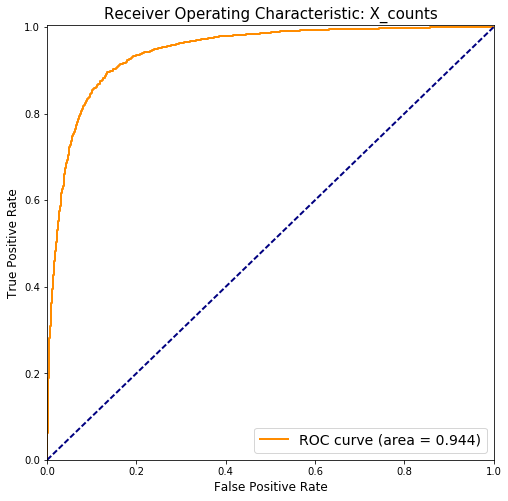


Best C value chosen: 0.007644


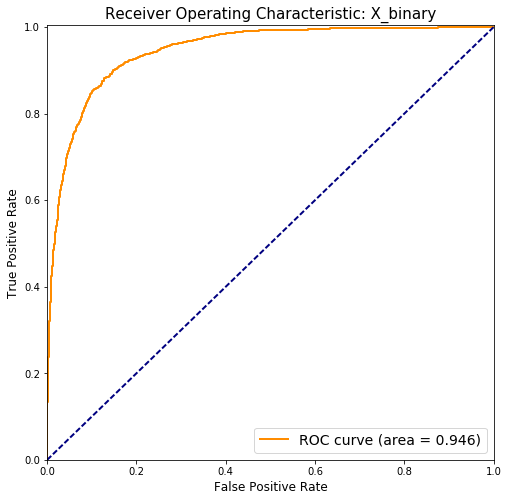


Best C value chosen: 0.151776


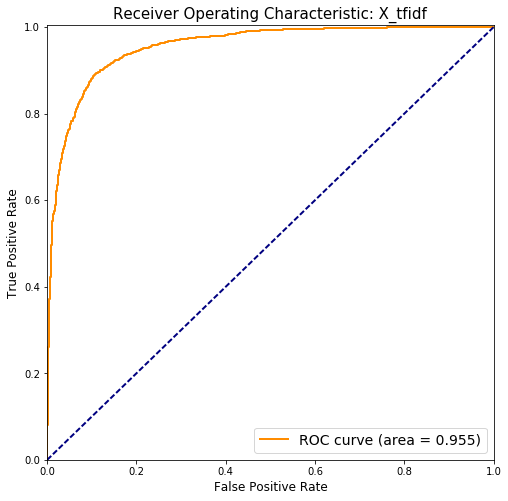

In [69]:
# generate an array of 30 random values of C uniformly 
# in the interval (1e-4, 1e4)
c_base = 10 * np.ones(30)
c_pow = np.random.uniform(-4, 4, 30)
c_range = np.power(c_base, c_pow)
print('\n------------------------------------------------------------------------')
print('30 C values to be evaluated:\n', c_range)
print('------------------------------------------------------------------------\n')

X_all = [X_counts, X_binary, X_tfidf]
X_names = ['X_counts', 'X_binary', 'X_tfidf']
C_best = np.zeros(4)

################ Training the models and predicting results for the first 3 design matrices #################
for i in range(3):
    X = X_all[i]
    # 80-20 splitting of the decision matrix
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    k_fold = cross_validation.KFold(n=y_train.shape[0],n_folds=5)
    RAscore = score(x_train, y_train, c_range, k_fold)
    fpr, tpr, roc_auc = test_pred(i, c_range, RAscore, x_train, y_train, x_test, y_test, C_best)
    ROC_plot(i, X_names[i], fpr, tpr, roc_auc)


Best C value chosen: 0.007644


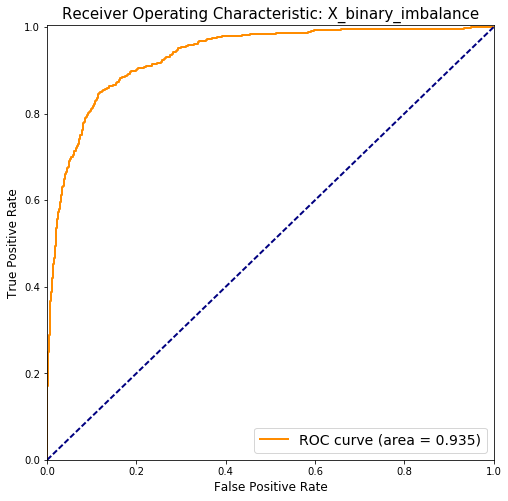

In [70]:
################ Training the model and predicting results for the imbalanced design matrix #################

y_imbalance = np.array(y_imbalance)

x_tr_imb, x_ts_imb, y_tr_imb, y_ts_imb = train_test_split(X_binary_imbalance, y_imbalance, 
                                                          test_size=0.2, random_state=0)

k_fold_imb = cross_validation.KFold(n=y_tr_imb.shape[0],n_folds=5)
imb_score = score(x_tr_imb, y_tr_imb, c_range, k_fold_imb)
fpr_imb, tpr_imb, roc_auc_imb = test_pred(3, c_range, imb_score, x_tr_imb, y_tr_imb, x_ts_imb, y_ts_imb, C_best)
ROC_plot(i,'X_binary_imbalance', fpr_imb, tpr_imb, roc_auc_imb)

In [91]:
C_best

array([ 0.00764431,  0.00764431,  0.15177603,  0.00764431])

In [93]:
# Read the test data
test_data = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print('test data shape:', test_data.shape)

# Create an empty list and append the clean reviews one by one
num_rev_test = len(test_data["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_rev_test):
    if((i+1) % 1000 == 0):
        print("Review %d of %d" % (i+1, num_rev_test))
    clean_review = review_to_words(test_data["review"][i] )
    clean_test_reviews.append(clean_review)
    
print("Test data cleaning and parsing done!")

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = scipy.sparse.csr_matrix(test_data_features)

test data shape: (25000, 2)
Cleaning and parsing the test set movie reviews...

Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000
Test data cleaning and parsing done!


In [110]:
# In this section, the best estimates of C values were used to retrain the
# model with LinearSVC classifier on the whole training set (25000 rows).
# The trained model then was used to make predictions.



M_counts = test_data_features
M_binary = M_counts > 0
M_tfidf = transformer.fit_transform(M_counts)

X = [X_counts, X_binary, M_tfidf, X_binary]
M = [M_counts, M_binary, M_tfidf, M_binary]


for i in range(4):
    # Use the LinearSVC to make sentiment label predictions
    clf_test = svm.LinearSVC(C=C_best[i])
    clf_test = clf_test.fit(X[i], y)
    result = clf_test.predict(M[i])
    
    # Copy the results to a pandas dataframe with an "id" column and
    # a "sentiment" column
    output = pd.DataFrame(data={"id":test_data["id"], "sentiment":result})
    
    # Use pandas to write the comma-separated output file
    output.to_csv("SVM_pred_rlt_" + str(i)+".csv", index=False, quoting=3)


### Discussion

* __The scores I obtained from Kaggle were: 0.82784, 0.87472, 0.76576, 0.87472.
In my case, the binary matrix produced the best result. The reason could be that the best C value this model picked worked very well for this data set. If we generate another set of 30 C values, the result could change. Overall, the four models all work well!__ 

* __On each ROC curves, the blue line is the baseline, which corresponds to random sampling, while the orange line shows the model performance. The lift between the model and the base case is about 70% for each case.__


# 4. Learning Curve Experiment

In [322]:
def plot_learning_curve_score(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=(9, 7))
    plt.title(title, fontsize = 15)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores = train_scores
    test_scores = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.show()

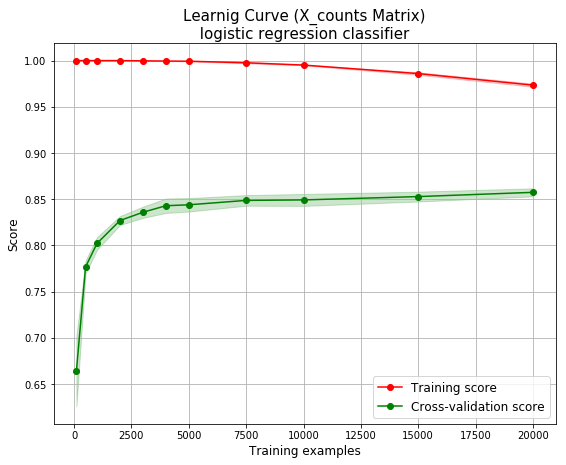

In [334]:
lr = linear_model.LogisticRegression()
kf_lr = cross_validation.KFold(y.shape[0], n_folds=5)

plt = plot_learning_curve_score(lr, "Learnig Curve (X_counts Matrix)\n logistic regression classifier ",
                                X_counts, y, cv=5, n_jobs=-1,
                                train_sizes = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000])

### Discussion

* __This learning curve is generated using logistic regression classifier.__

* __Training score measures how well the model fits the training data, while the test score indicates the performance of the model on new testing data. In other words, the first one is a measurement of training results, while the other one is a measurement of the generality of the model, on how good the model's prediction would be on unknown data set. There is commonly trade-off between these two scores. High training score could be a result of overfitting, which will be shown on the learning curve as small testing scores.__ 

* __On the graph shown above, the training score is decreasing with the increase in training data size, while the testing score is increasing as the training set size increases. This matches our prediction. It means the training of the model (classifier) tends to overfitting the training data as more and more data is used, while larger amount of data contributes to the improvement of the testing score. Also, the testing score tends to generally level off and flat out, and the gap between them becomes smaller.__
